# Hand Gesture RGB dataset (.csv) creation


In [4]:
# Institution: Carleton University
# Course: OSS4009 Capstone 
# Term: F22 - W23
#
# Filename: 0 - Pre1 - csv_dataset_creation.ipynb
#
# Students: Adam Thompson, Philippe Beaulieu
# Advisor:  Dr. Marzieh Amini
#
# Description: This program will create the dataset from the landmark taken from
#              Mediapipe Hand, they are saved in a .csv format under dataset_filename.
#              You can test the landmark with an image or live stream with a webcam in
#              the bottom code sections
#
#              This program will only look at the RGB images to extract the landmark.
#              The folder hierarchy is important to load the images, it is as follow:
#
#     TRAIN
#       -DEPTH
#          -folder0
#             - image0.jpg
#             - image1.jpg
#             - image2.jpg
#             - ...
#          -folder1
#             - image0.jpg
#             - image1.jpg
#             - image2.jpg
#             - ...
#          -...
#       -RGB
#          -folder0
#             - image0.jpg
#             - image1.jpg
#             - image2.jpg
#             - ...
#          -folder1
#             - image0.jpg
#             - image1.jpg
#             - image2.jpg
#             - ...
#          -...
#     TEST -> follow the same structure as train
#

Setup

In [1]:
import cv2
import mediapipe as mp
import time
import numpy as np
import pandas as pd
import json
import os

mp_hands          = mp.solutions.hands
mp_drawing        = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
points            = mp_hands.HandLandmark # Landmarks

path   = "TRAIN/RGB" # enter dataset path

data   = []

for p in points:
x = str(p)[13:]
    data.append(x + "_x")
    data.append(x + "_y")
    data.append(x + "_z")
data.append('target')               # added the target field depicting the group 0, 1, ...
data = pd.DataFrame(columns = data) # Empty dataset

dataset_filename = "dataset3.csv"

In [2]:
data

,WRIST_x,WRIST_y,WRIST_z,THUMB_CMC_x,THUMB_CMC_y,THUMB_CMC_z,THUMB_MCP_x,THUMB_MCP_y,THUMB_MCP_z,THUMB_IP_x,...,PINKY_PIP_x,PINKY_PIP_y,PINKY_PIP_z,PINKY_DIP_x,PINKY_DIP_y,PINKY_DIP_z,PINKY_TIP_x,PINKY_TIP_y,PINKY_TIP_z,target


Build the dataset (dataset3.csv) from images in a folder, and the class name taken from the folder name (class_name.json)

In [3]:
count  = 0
countF = 0
target = 0

class_name = []

with mp_hands.Hands(max_num_hands=1, 
                    model_complexity=1, 
                    min_detection_confidence=0.6, 
                    min_tracking_confidence=0.6) as hands:
        
    for folder in os.listdir(path):
        for img in os.listdir(path + "/" + folder):
            temp = []
            img  = cv2.imread(path + "/" + folder + "/" + img)
            blackie = np.zeros(img.shape) # Blank image
            results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            if results.multi_hand_landmarks:

                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(blackie, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                                              mp_drawing_styles.get_default_hand_landmarks_style(),
                                              mp_drawing_styles.get_default_hand_connections_style())
                    #print("Pose Landmarks:",hand_landmarks)

                    for point in mp_hands.HandLandmark:
                        nLandmark = hand_landmarks.landmark[point]
                        temp = temp + [nLandmark.x, nLandmark.y, nLandmark.z]
                        
                temp = temp + [target]

                #print("Pose temp:",temp)
                
                data.loc[count] = temp
                count +=1

            countF += 1  # add to valid image count
            cv2.imshow("Image", img)
            cv2.imshow("blackie",blackie)
            cv2.waitKey(10)

        target += 1   # add the count of image
        # add the folder name in a target list of actions
        class_name.append(folder)

data.to_csv(dataset_filename) # save the data as a csv file

with open("class_name.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable if the data is nested
    json.dump(class_name, f, indent=2) 

print("Valid images:",count)
print("Total Images:",countF)
print("Class Name:",class_name)

cv2.destroyAllWindows()

Valid images: 2742
Total Images: 3000
Class Name: ['1finger', '2finger', 'fist', 'palm', 'thumb_up']


Testing for accuracy

Accuracy score: 0.9976387249114522


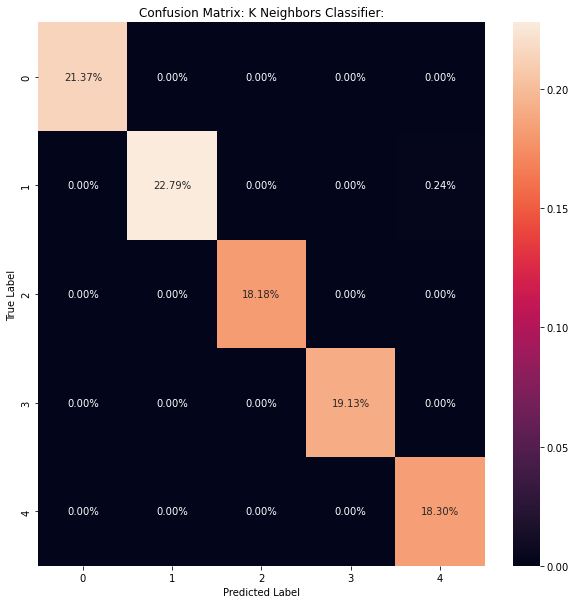

In [2]:
import time
import numpy as np
import pandas as pd
import json
import os

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

dataset_filename = "dataset3.csv"

import warnings
warnings.filterwarnings('ignore')

data              = pd.read_csv(dataset_filename,index_col=0) 
features,labels   = data.iloc[:,:63],data['target']

#{using SVC}
#model   = SVC(kernel = 'rbf')

#{using K Neighbors Classifier}  - good standing and sitting
model   = KNeighborsClassifier() # Initialize our classifier

# Split our data
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.20,
                                                          random_state=13)
# fit the data into the model
model.fit(train, train_labels)

# make a prediction
preds = model.predict(test)
#print("Prediction:", preds)

# Evaluate accuracy
print("Accuracy score:", accuracy_score(test_labels, preds))

#Get the confusion matrix
cf_matrix1 = confusion_matrix(test_labels, preds)
plt.figure(figsize=(10, 10))
plt.subplot(111)
sns.heatmap(cf_matrix1/np.sum(cf_matrix1), annot=True, fmt='.2%')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix: K Neighbors Classifier:')
plt.show()



Test an image

In [5]:
import cv2
import mediapipe as mp
import time
import numpy as np
import pandas as pd
import json
import os

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

dataset_filename = "dataset3.csv"

import warnings
warnings.filterwarnings('ignore')

# Colors.
blue        = (255, 127, 0)
green       = (127, 255, 0)
dark_blue   = (127, 20, 0)
light_green = (127, 233, 100)
yellow      = (0, 255, 255)
pink        = (255, 0, 255)
red         = (50, 50, 255)

colors = blue
asan = ""

mp_hands          = mp.solutions.hands
mp_drawing        = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

data              = pd.read_csv(dataset_filename,index_col=0) 
features,labels   = data.iloc[:,:63],data['target']

#{using SVC}
#model   = SVC(kernel = 'rbf')

#{using K Neighbors Classifier}  - good standing and sitting
model = KNeighborsClassifier() # Initialize our classifier

model.fit(features,labels)

with open("class_name.json", 'r') as f:
    class_name = json.load(f)

file    = "TEST/RGB/fist/frame592.jpg"   # "enter image path"
#file    = "TEST/DEPTH/fist/frame592.jpg"   # "enter image path"

with mp_hands.Hands(max_num_hands=1, 
                    model_complexity=0, 
                    min_detection_confidence=0.5, 
                    min_tracking_confidence=0.5) as hands:

    img     = cv2.imread(file)
    #blackim = np.zeros(img.shape) # Blank image
    ttemp   = []

    results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                                      mp_drawing_styles.get_default_hand_landmarks_style(),
                                      mp_drawing_styles.get_default_hand_connections_style())
            #print("Hand Landmarks:",hand_landmarks)

            for point in mp_hands.HandLandmark:
                nLandmark = hand_landmarks.landmark[point]
                ttemp = ttemp + [nLandmark.x, nLandmark.y, nLandmark.z]

        preds = model.predict([ttemp])
        asan = class_name[int(preds)]
        if (int(preds) == 0):
            colors = green
        elif (int(preds) == 1):
            colors = light_green
        elif (int(preds) == 2):
            colors = yellow
        elif (int(preds) == 3):
            colors = pink
        else:
            colors = red 
        
        print(asan)
        print("Prediction:",preds)

        #mpDraw.draw_landmarks(img, results.pose_landmarks, mpPose.POSE_CONNECTIONS) #draw landmarks on image
        #mpDraw.draw_landmarks(blackim, results.pose_landmarks, mpPose.POSE_CONNECTIONS) # draw landmarks on blackie
        cv2.putText(img, asan, (50,50), cv2.FONT_HERSHEY_SIMPLEX,1,colors,3)

        cv2.imshow("Intel D435 Hand Gesture",img)
        #cv2.imshow("Hand Landmarks",blackim)

cv2.waitKey(0)
cv2.destroyAllWindows()


fist
Prediction: [2.]


Test using a regular webcam

In [ ]:
import cv2
import mediapipe as mp
import time
import numpy as np
import pandas as pd
import json
import os
from sklearn.svm import SVC

dataset_filename = "dataset3.csv"

import warnings
warnings.filterwarnings('ignore')

# Colors.
green       = (127, 255, 0)
light_green = (127, 233, 100)
yellow      = (0, 255, 255)
pink        = (255, 0, 255)
red         = (50, 50, 255)
blue        = (255, 127, 0)
dark_blue   = (127, 20, 0)

colors = green
asan = ""

mp_hands          = mp.solutions.hands
mp_drawing        = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

data        = pd.read_csv(dataset_filename,index_col=0) 
feat, label = data.iloc[:,:63],data['target']

#{using SVC}
#model   = SVC(kernel = 'rbf')

#{using K Neighbors Classifier}  - good standing and sitting
model = KNeighborsClassifier() # Initialize our classifier

model.fit(feat, label) # Train our classifier


with open("class_name.json", 'r') as f:
    class_name = json.load(f)


# For webcam input:
cap = cv2.VideoCapture(3)      # use your webcam number location, '0' is the first camera/app

with mp_hands.Hands(max_num_hands=1, 
                    model_complexity=0, 
                    min_detection_confidence=0.5, 
                    min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue

        # process the image to extract the hand landmark (coordinates)
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        ttemp   = []
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                                          mp_drawing_styles.get_default_hand_landmarks_style(),
                                          mp_drawing_styles.get_default_hand_connections_style())

                # extract the landmark
                for point in mp_hands.HandLandmark:
                    nLandmark = hand_landmarks.landmark[point]
                    ttemp = ttemp + [nLandmark.x, nLandmark.y, nLandmark.z]

            # make prediction, identify the action, select color of text
            preds = model.predict([ttemp])
            asan = class_name[int(preds)]      
            if (int(preds) == 0):
                colors = green
            elif (int(preds) == 1):
                colors = light_green
            elif (int(preds) == 2):
                colors = yellow
            elif (int(preds) == 3):
                colors = pink
            else:
                colors = red                

        # Draw the pose annotation on the image.
        cv2.putText(image, asan, (50,50), cv2.FONT_HERSHEY_SIMPLEX,1,colors,3)

        # display the image
        cv2.imshow('MediaPipe Hand', image)
        if cv2.waitKey(5) == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()
